In [1]:
import numpy as np
import torch
import random
import math
from collections import namedtuple
import os
import time

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.signal import medfilt

""" Note: the code is not optimized for GPU
"""
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [10]:
#Mathematica exported pt array to python array
array = np.loadtxt('test.csv', delimiter=",")
array

array([[ 5.16601049,  5.16601049],
       [ 6.00383107,  0.        ],
       [ 6.74624857,  4.57775407],
       [ 3.35733921,  0.        ],
       [-1.05853617,  5.96498441],
       [-4.35714012,  0.        ],
       [-6.86150897,  4.52874046],
       [ 0.        ,  0.        ]])

In [3]:
#Separate x axis and curve pts 
def ptseparator(array):
    xaxis = list(list())
    curve = list(list())
    for i in array:
        if i[1]==0:
            xaxis.append(i)
        else:
            curve.append(i)
    return xaxis, curve  

xaxis, curve = np.array(ptseparator(array))
print("xaxis array = \n", xaxis)
print("curve array = \n", curve)

xaxis array = 
 [[ 6.00383107  0.        ]
 [ 3.35733921  0.        ]
 [-4.35714012  0.        ]
 [ 0.          0.        ]]
curve array = 
 [[ 5.16601049  5.16601049]
 [ 6.74624857  4.57775407]
 [-1.05853617  5.96498441]
 [-6.86150897  4.52874046]]


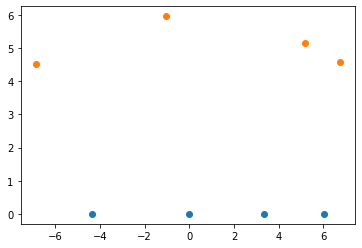

In [4]:
#Plotting of the Points
x, y = xaxis.T
plt.scatter(x,y);

x, y = curve.T
plt.scatter(x,y);

plt.show()

In [83]:
def slope_func(point, x):
    if (point[1]-x[1]) ==0:
        s = +100
    elif (point[1]!=0) and (x[1]!=0):
        s = +100
    else: 
        s = (point[0]-x[0])/(point[1]-x[1])
    return s


def slope_matrix(a, b):
    mat = np.zeros((len(a), len(b)))
    for i in range(len(a)):
        for j in range(len(b)):
            mat[i][j] = slope_func(a[j], b[i]);
    return mat

In [84]:
#Slope Matrix ((i, j) -> i = pts o2f x axis , j = pts on curve, (i, j) represents slope from j to i 
np.set_printoptions(precision=3)
sl_mat = slope_matrix(coords, coords)
print(sl_mat)

[[100.     -0.162 100.      0.35  100.      1.843 100.      1.   ]
 [ -0.162 100.      0.162 100.     -1.184 100.     -2.841 100.   ]
 [100.      0.162 100.      0.74  100.      2.426 100.      1.474]
 [  0.35  100.      0.74  100.     -0.74  100.     -2.256 100.   ]
 [100.     -1.184 100.     -0.74  100.      0.553 100.     -0.177]
 [  1.843 100.      2.426 100.      0.553 100.     -0.553 100.   ]
 [100.     -2.841 100.     -2.256 100.     -0.553 100.     -1.515]
 [  1.    100.      1.474 100.     -0.177 100.     -1.515 100.   ]]


4

## Define the state
We now define the state tuple, containing a graph (given by a weights matrix `W`), the noode coordinates `coords` and the partial solution (list of visited nodes).
We also define the function `state2tens`, which translates such tuples into tensors (partially loosing the sequence order information).

In [66]:
State = namedtuple('State', ('W', 'coords', 'partial_solution'))
  
def state2tens(state):
    """ Creates a Pytorch tensor representing the history of visited nodes, from a (single) state tuple.
        
        Returns a (Nx5) tensor, where for each node we store whether this node is in the sequence,
        whether it is first or last, and its (x,y) coordinates.
    """
    solution = set(state.partial_solution)
    sol_last_node = state.partial_solution[-1] if len(state.partial_solution) > 0 else -1
    sol_first_node = state.partial_solution[0] if len(state.partial_solution) > 0 else -1
    coords = state.coords
    nr_nodes = coords.shape[0]

    xv = [[(1 if i in solution else 0),
           (1 if i == sol_first_node else 0),
           (1 if i == sol_last_node else 0),
           coords[i,0],
           coords[i,1]
          ] for i in range(nr_nodes)]
    
    return torch.tensor(xv, dtype=torch.float32, requires_grad=False, device=device)

## The Q-Function
Below, we write the neural network that will parameterize the function Q(s, a).


In [67]:
class QNet(nn.Module):
    """ The neural net that will parameterize the function Q(s, a)
    
        The input is the state (containing the graph and visited nodes),
        and the output is a vector of size N containing Q(s, a) for each of the N actions a.
    """    
    
    def __init__(self, emb_dim, T=4):
        """ emb_dim: embedding dimension p
            T: number of iterations for the graph embedding
        """
        super(QNet, self).__init__()
        self.emb_dim = emb_dim
        self.T = T
        
        # We use 5 dimensions for representing the nodes' states:
        # * A binary variable indicating whether the node has been visited
        # * A binary variable indicating whether the node is the first of the visited sequence
        # * A binary variable indicating whether the node is the last of the visited sequence
        # * The (x, y) coordinates of the node.
        self.node_dim = 5
        
        # We can have an extra layer after theta_1 (for the sake of example to make the network deeper)
        nr_extra_layers_1 = 1
        
        # Build the learnable affine maps:
        self.theta1 = nn.Linear(self.node_dim, self.emb_dim, True)
        self.theta2 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta3 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta4 = nn.Linear(1, self.emb_dim, True)
        self.theta5 = nn.Linear(2*self.emb_dim, 1, True)
        self.theta6 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta7 = nn.Linear(self.emb_dim, self.emb_dim, True)
        
        self.theta1_extras = [nn.Linear(self.emb_dim, self.emb_dim, True) for _ in range(nr_extra_layers_1)]
        
    def forward(self, xv, Ws):
        # xv: The node features (batch_size, num_nodes, node_dim)
        # Ws: The graphs (batch_size, num_nodes, num_nodes)
        
        num_nodes = xv.shape[1]
        batch_size = xv.shape[0]
        
        # pre-compute 1-0 connection matrices masks (batch_size, num_nodes, num_nodes)
        conn_matrices = torch.where(Ws > 0, torch.ones_like(Ws), torch.zeros_like(Ws)).to(device)
        
        # Graph embedding
        # Note: we first compute s1 and s3 once, as they are not dependent on mu
        mu = torch.zeros(batch_size, num_nodes, self.emb_dim, device=device)
        s1 = self.theta1(xv)  # (batch_size, num_nodes, emb_dim)
        for layer in self.theta1_extras:
            s1 = layer(F.relu(s1))  # we apply the extra layer
        
        s3_1 = F.relu(self.theta4(Ws.unsqueeze(3)))  # (batch_size, nr_nodes, nr_nodes, emb_dim) - each "weigth" is a p-dim vector        
        s3_2 = torch.sum(s3_1, dim=1)  # (batch_size, nr_nodes, emb_dim) - the embedding for each node
        s3 = self.theta3(s3_2)  # (batch_size, nr_nodes, emb_dim)
        
        for t in range(self.T):
            s2 = self.theta2(conn_matrices.matmul(mu))    
            mu = F.relu(s1 + s2 + s3)
            
        """ prediction
        """
        # we repeat the global state (summed over nodes) for each node, 
        # in order to concatenate it to local states later
        global_state = self.theta6(torch.sum(mu, dim=1, keepdim=True).repeat(1, num_nodes, 1))
        
        local_action = self.theta7(mu)  # (batch_dim, nr_nodes, emb_dim)
            
        out = F.relu(torch.cat([global_state, local_action], dim=2))
        return self.theta5(out).squeeze(dim=2)

In [69]:
""" See what the model returns
"""
model = QNet(3, T=1).to(device)
coords, W_np = coords, sl_mat
W = torch.tensor(W_np, dtype=torch.float32, device=device)
xv = torch.rand((1, W.shape[0], 5)).to(device) # random node state
Ws = W.unsqueeze(0)

y = model(xv, Ws)
print('model output: {}'.format(y))

model output: tensor([[64.6817, 64.6546, 65.7846, 64.6543, 64.6494, 64.6554, 65.8637, 64.6544]],
       grad_fn=<SqueezeBackward1>)


In [70]:
class QFunction():
    def __init__(self, model, optimizer, lr_scheduler):
        self.model = model  # The actual QNet
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_fn = nn.MSELoss()
    
    def predict(self, state_tsr, W):
        # batch of 1 - only called at inference time
        with torch.no_grad():
            estimated_rewards = self.model(state_tsr.unsqueeze(0), W.unsqueeze(0))
        return estimated_rewards[0]
                
    def get_best_action(self, state_tsr, state):
        """ Computes the best (greedy) action to take from a given state
            Returns a tuple containing the ID of the next node and the corresponding estimated reward
        """
        W = state.W
        estimated_rewards = self.predict(state_tsr, W)  # size (nr_nodes,)
        sorted_reward_idx = estimated_rewards.argsort(descending=True)
        
        solution = state.partial_solution
        
        already_in = set(solution)
        for idx in sorted_reward_idx.tolist():
            if (len(solution) == 0 or W[solution[-1], idx] > 0) and idx not in already_in:
                return idx, estimated_rewards[idx].item()
        
    def batch_update(self, states_tsrs, Ws, actions, targets):
        """ Take a gradient step using the loss computed on a batch of (states, Ws, actions, targets)
        
            states_tsrs: list of (single) state tensors
            Ws: list of W tensors
            actions: list of actions taken
            targets: list of targets (resulting estimated rewards after taking the actions)
        """        
        Ws_tsr = torch.stack(Ws).to(device)
        xv = torch.stack(states_tsrs).to(device)
        self.optimizer.zero_grad()
        
        # the rewards estimated by Q for the given actions
        estimated_rewards = self.model(xv, Ws_tsr)[range(len(actions)), actions]
        
        loss = self.loss_fn(estimated_rewards, torch.tensor(targets, device=device))
        loss_val = loss.item()
        
        loss.backward()
        self.optimizer.step()        
        self.lr_scheduler.step()
        
        return loss_val

In [71]:
# Note: we store state tensors in experience to compute these tensors only once later on
Experience = namedtuple('Experience', ('state', 'state_tsr', 'action', 'reward', 'next_state', 'next_state_tsr'))

class Memory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.nr_inserts = 0
        
    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity
        self.nr_inserts += 1
        
    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return min(self.nr_inserts, self.capacity)

In [72]:
def total_distance(solution, W):
    if len(solution) < 2:
        return 0  # there is no travel
    
    total_dist = 0
    for i in range(len(solution) - 1):
        total_dist += W[solution[i], solution[i+1]].item()
        
    # if this solution is "complete", go back to initial point
    if len(solution) == W.shape[0]:
        total_dist += W[solution[-1], solution[0]].item()

    return total_dist
        
def is_state_final(state):
    return len(set(state.partial_solution)) == state.W.shape[0]

def get_next_neighbor_random(state):
    solution, W = state.partial_solution, state.W
    
    if len(solution) == 0:
        return random.choice(range(W.shape[0]))
    already_in = set(solution)
    candidates = list(filter(lambda n: n.item() not in already_in, W[solution[-1]].nonzero()))
    if len(candidates) == 0:
        return None
    return random.choice(candidates).item()

In [75]:
SEED = 1  # A seed for the random number generator

# Graph
NR_NODES = 10  # Number of nodes N
EMBEDDING_DIMENSIONS = 5  # Embedding dimension D
EMBEDDING_ITERATIONS_T = 1  # Number of embedding iterations T

# Learning
NR_EPISODES = 4001
MEMORY_CAPACITY = 10000
N_STEP_QL = 2  # Number of steps (n) in n-step Q-learning to wait before computing target reward estimate
BATCH_SIZE = 16

GAMMA = 0.9
INIT_LR = 5e-3
LR_DECAY_RATE = 1. - 2e-5  # learning rate decay

MIN_EPSILON = 0.1
EPSILON_DECAY_RATE = 6e-4  # epsilon decay

FOLDER_NAME = './models'  # where to checkpoint the best models

In [76]:
def init_model(fname=None):
    """ Create a new model. If fname is defined, load the model from the specified file.
    """
    Q_net = QNet(EMBEDDING_DIMENSIONS, T=EMBEDDING_ITERATIONS_T).to(device)
    optimizer = optim.Adam(Q_net.parameters(), lr=INIT_LR)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY_RATE)
    
    if fname is not None:
        checkpoint = torch.load(fname)
        Q_net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    
    Q_func = QFunction(Q_net, optimizer, lr_scheduler)
    return Q_func, Q_net, optimizer, lr_scheduler

def checkpoint_model(model, optimizer, lr_scheduler, loss, 
                     episode, avg_length):
    if not os.path.exists(FOLDER_NAME):
        os.makedirs(FOLDER_NAME)
    
    fname = os.path.join(FOLDER_NAME, 'ep_{}'.format(episode))
    fname += '_length_{}'.format(avg_length)
    fname += '.tar'
    
    torch.save({
        'episode': episode,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'loss': loss,
        'avg_length': avg_length
    }, fname)

In [78]:
# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

for episode in range(NR_EPISODES):
    # sample a new random graph
    coords, W_np = coords, sl_mat
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    
    # current partial solution - a list of node index
    solution = [random.randint(0, NR_NODES-1)]
    
    # current state (tuple and tensor)
    current_state = State(partial_solution=solution, W=sl_mat, coords=coords)
    current_state_tsr = state2tens(current_state)
    
    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []
    
    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)
    
    nr_explores = 0
    t = -1
    while not is_state_final(current_state):
        t += 1  # time step of this episode
        
        if epsilon >= random.random():
            # explore
            next_node = get_next_neighbor_random(current_state)
            nr_explores += 1
        else:
            # exploit
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))
        
        next_solution = solution + [next_node]
        
        # reward observed for taking this step        
        reward = -(total_distance(next_solution, W) - total_distance(solution, W))
        
        next_state = State(partial_solution=next_solution, W=W, coords=coords)
        next_state_tsr = state2tens(next_state)
        
        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)
        
        # store our experience in memory, using n-step Q-learning:
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))
            
        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n], 
                                           action=actions[-n], 
                                           reward=sum(rewards[-n:]), 
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))
        
        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_solution
        
        # take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 2000:
            experiences = memory.sample_batch(BATCH_SIZE)
            
            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []
            
            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr, 
                                                            experience.next_state)
                    target += GAMMA * best_reward
                batch_targets.append(target)
                
            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)
            
            """ Save model when we reach a new low average path length
            """
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length)
                
    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (W.clone(), coords.copy(), [n for n in solution])

ValueError: can only convert an array of size 1 to a Python scalar